In [1]:
# these lines install modules cleantext and emoji. 
# Module cleantext is used to clean text data including: conversion of texts to lower case, removing unecessary panctuation and removal of stopwords.
# module emoji is needed to remove emocations from text.
!pip install cleantext
!pip install emoji==1.7
!pip install wget 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=7520b0e41f6d3c56d2b591ff92f8f43cc692c865adf0aa3a171bc35b82d597cc
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.1.0
    Uninstalling emoji-2.1.0:
      Successfully uninstalled emoji-2.1.0
  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0bfa116969a701153f7fbe8369dca08b12e0e0ebf0f2877189cb0c998c6d2266
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# here are all the modules used during this analysis. 
# you can use help() to get documentation of each, eg help('pandas') will give you documentation of pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import cleantext 
import emoji 
import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras import datasets, layers, models,Input,Model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape,GlobalAveragePooling1D
import re
import keras
import shutil
import string
import random
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
import wget
import zipfile
import os
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from functools import reduce
from sklearn.tree import DecisionTreeClassifier as DR
from sklearn.ensemble import GradientBoostingClassifier as GBoost

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import pickle
from sklearn.decomposition import PCA
# call backs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2023-01-10 17:06:04.721796: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-10 17:06:04.721875: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-10 17:06:04.723257: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [3]:
with open("/kaggle/input/fakerealmainoutputdata/kmea.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/predictors.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/tests.pkl","rb") as file:
    tests=pickle.load(file)
    
test=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/train")
train=tf.data.experimental.load("/kaggle/input/missingtest/train")
valid=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/valid")
model = keras.models.load_model('/kaggle/input/fakerealmainoutputdata/model')

train0=train
test0=test
valid0=valid

2023-01-10 17:06:04.893103: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data


2023-01-10 17:06:21.740714: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
with open("/kaggle/input/fakerealmainoutputdata/mod_hist.pkl","rb") as file:
    mod=pickle.load(file)

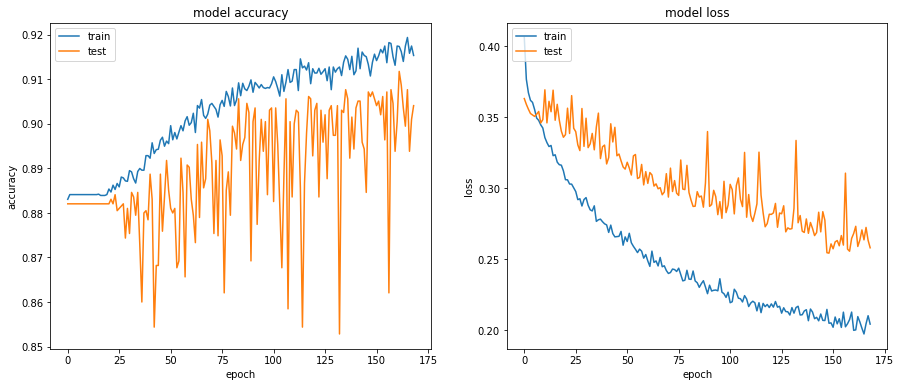

In [6]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(mod['accuracy'])
ax[0].plot(mod['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(mod['loss'])
ax[1].plot(mod['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('othercomparing1.png')

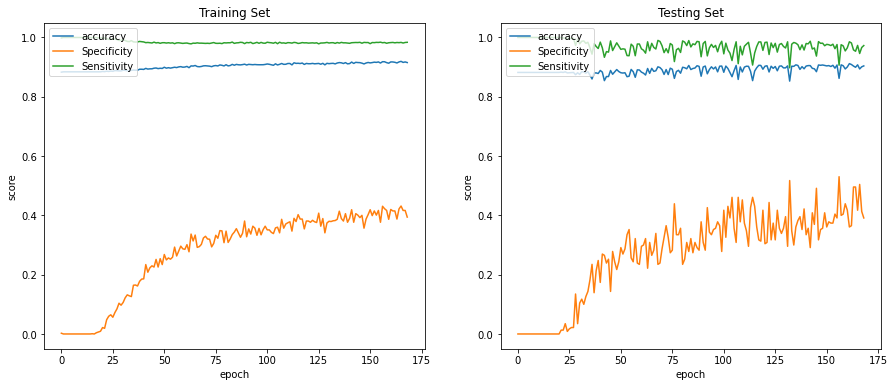

In [7]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(mod['val_accuracy'])
ax[1].plot(mod['val_Sensitivity'])
ax[1].plot(mod['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Specificity','Sensitivity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(mod['accuracy'])
ax[0].plot(mod['Sensitivity'])
ax[0].plot(mod['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Specificity','Sensitivity','Precision','F1 score'], loc='upper left')
plt.savefig('othercomparing2.png')

In [8]:
model.compile(                                              
  optimizer='adam',                                         # compile the model with adams optimizers
  loss="categorical_crossentropy",                          # use categorical cross entropy loss functions
  metrics=["accuracy",                                      # while fitting the model will be evaluated on the testing set using:- Accuracy
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),                                                              # - Sensitivity                                               
           tf.keras.metrics.Recall(name="Specificity",class_id=1),                                                              # - Specificity 
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])                                                          # - precision
modelpred=np.argmax(model.predict(test), axis=1)

In [9]:
mod1=model.evaluate(test)[1:6]
mod1=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision',"F-score"],
    "Original Dataset":[np.round(float(i), 4) for i in mod1]}) 
mod1

31/31 [==============================] - 22s 620ms/step - loss: 0.2581 - accuracy: 0.9041 - Sensitivity: 0.3913 - Specificity: 0.9727 - Precision: 0.6569 - f1_score: 0.9041


,Measure,Original Dataset
0,Accuracy,0.9041
1,Sensitivity,0.3913
2,Specificty,0.9727
3,Precision,0.6569
4,F-score,0.9041


In [10]:
def labels(ds):
    labels=[]
    for batch in ds:
        articles,labelss=batch
        labelss=labelss.numpy()
        labels.append(labelss)
    labels=np.concatenate(labels)
    return labels

label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [11]:
# feature extraction model
feature_miner=Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="Bidirectional2").output,name="feature_miner"
)

In [12]:
feature_miner.summary()

Model: "feature_miner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_articles (InputLayer)  [(None, None)]            0         
_________________________________________________________________
embeddinglayer (Embedding)   (None, None, 100)         2000100   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 8)           4008      
_________________________________________________________________
dropout1 (Dropout)           (None, None, 8)           0         
_________________________________________________________________
batchnormalization (BatchNor (None, None, 8)           32        
_________________________________________________________________
Bidirectional2 (Bidirectiona (None, 16)              

In [13]:
kmeans_pred=kmea.predict(tests)
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.43538461538461537
0.5646153846153846


In [14]:
kmeans_pred1=kmea.predict(tests)
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [15]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,kmeans_pred),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=0),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=1),
                        metrics.precision_score(label_test,kmeans_pred,pos_label=0),
                        metrics.f1_score(label_test,kmeans_pred,pos_label=0)]})
 

,Measure,Original Dataset
0,Accuracy,0.564615
1,Sensitivity,0.917391
2,Specitivity,0.517442
3,Precision,0.202690
4,F1_score,0.332022


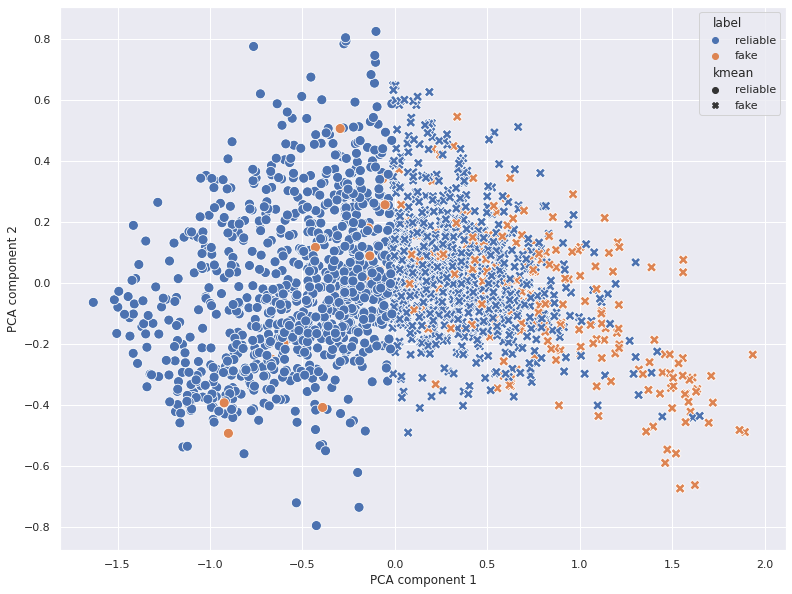

In [16]:
pca = PCA(2)
pcas= pd.DataFrame(pca.fit_transform(tests), columns = ['x','y'])
pcas['kmean']= kmeans_pred
pcas['label']= label_test

def to_binary_labels(labels):
    if labels ==0:
        x="fake"
    else:
        x= "reliable" 
    return x

pcas['label']=pd.Series (list(map(to_binary_labels,pcas['label'])))
pcas['kmean']=pd.Series (list(map(to_binary_labels,pcas['kmean'])))
sns.set(rc={"figure.figsize":(13, 10)}) 
sns.scatterplot(data=pcas, x="x", y="y",s=100,style="kmean",hue='label')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.savefig('PCA.png')

In [17]:
sensdeep=metrics.recall_score(label_test, modelpred,pos_label=0)
senskmeans=metrics.recall_score(label_test,kmeans_pred,pos_label=0)
specdeep=metrics.recall_score(label_test, modelpred,pos_label=1)
speckmean=metrics.recall_score(label_test,kmeans_pred,pos_label=1)
fak=np.array([np.count_nonzero(label_test == 0),np.count_nonzero(label_test == 1)])/sum([np.count_nonzero(label_test == 0),np.count_nonzero(label_test == 1)])
def weighting(kmeans_pred,modelpred):
    conditionals= [] 
    for i in range(len(kmeans_pred)):
        if modelpred[i]==0 and kmeans_pred[i]==0:
            x=[sensdeep*senskmeans,(1-specdeep)*(1-speckmean)]*fak
        elif modelpred[i]==1 and kmeans_pred[i]==1:
            x=[(1-sensdeep)*(1-senskmeans),specdeep*speckmean]*fak
        elif modelpred[i]==0 and kmeans_pred[i]==1:
            x=[sensdeep*(1-senskmeans),(1-specdeep)*speckmean]*fak
        else:
            x=[(1-sensdeep)*senskmeans,specdeep*(1-speckmean)]*fak
        conditionals.append(x)
        #unconditionals.append((np.array(x)/sum(x)).tolist())
    preds=np.argmax(conditionals,axis=1)
    return preds
preds=weighting(kmeans_pred,modelpred)

In [18]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})
 

,Measure,Original Dataset
0,Accuracy,0.904103
1,Sensitivity,0.391304
2,Specitivity,0.972674
3,Precision,0.656934
4,F1_score,0.490463


In [19]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_test

In [20]:
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB() # create a classifier
mod=nv.fit(xt,yt) # fitting the data
preds = nv.predict(xt)

In [21]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.904103
1,Sensitivity,0.391304
2,Specitivity,0.972674
3,Precision,0.656934
4,F1_score,0.490463


# validation set

In [22]:
modelpred=np.argmax(model.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [23]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_valid

In [24]:
preds = nv.predict(xt)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})


,Measure,Original Dataset
0,Accuracy,0.907692
1,Sensitivity,0.388889
2,Specitivity,0.972318
3,Precision,0.636364
4,F1_score,0.482759


# model 1

In [25]:
with open("/kaggle/input/benchmarkmodelsfake3/kmea1.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/benchmarkmodelsfake3/predictors1.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/benchmarkmodelsfake3/tests1.pkl","rb") as file:
    tests=pickle.load(file)

test=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/fakenewstest")
train=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/fakenewstrain")
valid=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/fakenewsvalid")
model1 = keras.models.load_model('/kaggle/input/benchmarkmodelsfake3/model1')

train1=train
test1=test
valid1=valid

In [26]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data


In [27]:
model1.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

mod2=model1.evaluate(test)[1:6]
mod2=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod2]})
mod2

15/15 [==============================] - 11s 434ms/step - loss: 0.2759 - accuracy: 0.8968 - Sensitivity: 0.8415 - Specificity: 0.9563 - Precision: 0.9539 - f1_score: 0.8968


,Measure,Original Dataset
0,Accuracy,0.8968
1,Sensitivity,0.8415
2,Specificty,0.9563
3,Precision,0.9539
4,F1 score,0.8968


In [28]:
label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [29]:
modelpred=np.argmax(model1.predict(test), axis=1)
kmeans_pred=kmea.predict(tests)
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.9063157894736842
0.09368421052631579


In [30]:
kmeans_pred1=kmea.predict(tests)
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [31]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,kmeans_pred),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=0),
                        metrics.recall_score(label_test, kmeans_pred,pos_label=1),
                        metrics.precision_score(label_test,kmeans_pred,pos_label=0),
                        metrics.f1_score(label_test,kmeans_pred,pos_label=0)]})
 

,Measure,Original Dataset
0,Accuracy,0.906316
1,Sensitivity,0.873984
2,Specitivity,0.941048
3,Precision,0.940919
4,F1_score,0.906217


In [32]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_test

In [33]:
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB() # create a classifier
mod=nv.fit(xt,yt) # fitting the data
preds = nv.predict(xt)

In [34]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.908421
1,Sensitivity,0.878049
2,Specitivity,0.941048
3,Precision,0.941176
4,F1_score,0.908517


In [35]:
#Validation

In [36]:
modelpred=np.argmax(model1.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [37]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_valid

In [38]:
preds = nv.predict(xt)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})


,Measure,Original Dataset
0,Accuracy,0.501577
1,Sensitivity,0.993590
2,Specitivity,0.024845
3,Precision,0.496795
4,F1_score,0.662393


# models 2

In [39]:
with open("/kaggle/input/benchmarkmodelsfake3/kmea2.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/benchmarkmodelsfake3/predictors2.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/benchmarkmodelsfake3/tests2.pkl","rb") as file:
    tests=pickle.load(file)
    
test=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/authenticnewstest")
train=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/authenticewstrain")
valid=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/authenticnewsvalid")
model2 = keras.models.load_model('/kaggle/input/benchmarkmodelsfake3/model2')

train2=train
test2=test
valid2=valid

In [40]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data


In [41]:
model2.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

mod2=model2.evaluate(test)[1:6]
mod2=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod2]})
mod2

106/106 [==============================] - 26s 221ms/step - loss: 0.0115 - accuracy: 0.9978 - Sensitivity: 0.9980 - Specificity: 0.9975 - Precision: 0.9977 - f1_score: 0.9978


,Measure,Original Dataset
0,Accuracy,0.9978
1,Sensitivity,0.9980
2,Specificty,0.9975
3,Precision,0.9977
4,F1 score,0.9978


In [42]:
label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [43]:
modelpred=np.argmax(model2.predict(test), axis=1)
kmeans_pred=kmea.predict(tests)
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.9976243504083148
0.0023756495916852265


In [44]:
kmeans_pred1=kmea.predict(tests)
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [45]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_test

In [46]:
nv = GaussianNB() # create a classifier
mod=nv.fit(xt,yt) # fitting the data
preds = nv.predict(xt)

In [47]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.997773
1,Sensitivity,0.998009
2,Specitivity,0.997516
3,Precision,0.997725
4,F1_score,0.997867


In [48]:
#Validation

In [49]:
modelpred=np.argmax(model2.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [50]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_valid

In [51]:
preds = nv.predict(xt)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})


,Measure,Original Dataset
0,Accuracy,0.998664
1,Sensitivity,1.000000
2,Specitivity,0.997260
3,Precision,0.997398
4,F1_score,0.998697


In [52]:
# trying on other models

# Model 3

In [53]:
with open("/kaggle/input/benchmarkmodelsfake3/kmea3.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/benchmarkmodelsfake3/predictors3.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/benchmarkmodelsfake3/tests3.pkl","rb") as file:
    tests=pickle.load(file)
    
test=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/liartest")
train=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/liartrain")
valid=tf.data.experimental.load("/kaggle/input/benchmarkmodelsfake3/liarvalid")
model3 = keras.models.load_model('/kaggle/input/benchmarkmodelsfake3/model3')

train3=train
test3=test
valid3=valid

In [54]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data


In [55]:
model3.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

mod3=model3.evaluate(test)[1:6]
mod3=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod3]})
mod3

20/20 [==============================] - 3s 13ms/step - loss: 0.5649 - accuracy: 0.7309 - Sensitivity: 0.0000e+00 - Specificity: 1.0000 - Precision: 0.0000e+00 - f1_score: 0.7309


,Measure,Original Dataset
0,Accuracy,0.7309
1,Sensitivity,0.0000
2,Specificty,1.0000
3,Precision,0.0000
4,F1 score,0.7309


In [56]:
label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [57]:
modelpred=np.argmax(model3.predict(test), axis=1)
kmeans_pred=kmea.predict(tests)
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.5966850828729282
0.40331491712707185


In [58]:
kmeans_pred1=kmea.predict(tests)
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [59]:
preds=kmeans_pred
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.596685
1,Sensitivity,0.656891
2,Specitivity,0.574514
3,Precision,0.362460
4,F1_score,0.467153


In [60]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_test

In [61]:
nv = GaussianNB() # create a classifier
mod=nv.fit(xt,yt) # fitting the data
preds = nv.predict(xt)

In [62]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Measure,Original Dataset
0,Accuracy,0.73086
1,Sensitivity,0.00000
2,Specitivity,1.00000
3,Precision,0.00000
4,F1_score,0.00000


In [63]:
# validation

In [64]:
modelpred=np.argmax(model3.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [65]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_valid

In [66]:
preds = nv.predict(xt)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Measure,Original Dataset
0,Accuracy,0.704829
1,Sensitivity,0.000000
2,Specitivity,1.000000
3,Precision,0.000000
4,F1_score,0.000000


# model 4

In [67]:
with open("/kaggle/input/tweets/kmea4.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/tweets/predictors4.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/tweets/tests4.pkl","rb") as file:
    tests=pickle.load(file)
    
test=tf.data.experimental.load("/kaggle/input/tweets1/tweetstest")
train=tf.data.experimental.load("/kaggle/input/tweets1/tweetstrain")
valid=tf.data.experimental.load("/kaggle/input/tweets1/tweetsvalid")
model4 = keras.models.load_model('/kaggle/input/tweets/model4')
train4=train
test4=test
valid4=valid

In [68]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data


In [69]:
model4.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])
mod4=model4.evaluate(test)[1:6]
mod4=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision','F1 score'],
    "Original Dataset":[np.round(float(i), 4) for i in mod4]})
mod4

40/40 [==============================] - 3s 13ms/step - loss: 0.4094 - accuracy: 0.8173 - Sensitivity: 0.8194 - Specificity: 0.8151 - Precision: 0.8244 - f1_score: 0.8173


,Measure,Original Dataset
0,Accuracy,0.8173
1,Sensitivity,0.8194
2,Specificty,0.8151
3,Precision,0.8244
4,F1 score,0.8173


In [70]:
label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [71]:
modelpred=np.argmax(model4.predict(test), axis=1)
kmeans_pred=kmea.predict(tests)
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.19770660340055357
0.8022933965994464


In [72]:
kmeans_pred1=kmea.predict(tests)
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [73]:
preds=kmeans_pred
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.802293
1,Sensitivity,0.887010
2,Specitivity,0.712541
3,Precision,0.765760
4,F1_score,0.821937


In [74]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_test

In [75]:
nv = GaussianNB() # create a classifier
mod=nv.fit(xt,yt) # fitting the data
preds = nv.predict(xt)

In [76]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.817319
1,Sensitivity,0.819370
2,Specitivity,0.815147
3,Precision,0.824439
4,F1_score,0.821897


In [77]:
modelpred=np.argmax(model4.predict(valid), axis=1)
valids=feature_miner.predict(valid)
kmeans_pred=kmea.predict(valids)

if np.mean(kmeans_pred1==label_test)>=np.mean((1-kmeans_pred1)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [78]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_valid

In [79]:
preds = nv.predict(xt)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_valid,preds),
                        metrics.recall_score(label_valid, preds,pos_label=0),
                        metrics.recall_score(label_valid, preds,pos_label=1),
                        metrics.precision_score(label_valid,preds,pos_label=0),
                        metrics.f1_score(label_valid,preds,pos_label=0)]})


,Measure,Original Dataset
0,Accuracy,0.541538
1,Sensitivity,0.123494
2,Specitivity,0.977987
3,Precision,0.854167
4,F1_score,0.215789


In [80]:
# trying with mod2

In [81]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train2.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train0.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid0.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test0.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data

with open("/kaggle/input/benchmarkmodelsfake3/kmea2.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/predictors.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/tests.pkl","rb") as file:
    tests=pickle.load(file)

In [82]:
label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [83]:
modelpred=np.argmax(model2.predict(test), axis=1)
kmeans_pred=kmea.predict(tests)
print(np.mean(kmeans_pred==label_test))
print(np.mean(np.mean((1-kmeans_pred)==label_test)))

0.8138461538461539
0.18615384615384614


In [84]:
kmeans_pred1=kmea.predict(tests)
if np.mean(kmeans_pred==label_test)>=np.mean((1-kmeans_pred)==label_test):
    kmeans_pred=kmeans_pred
else:
    kmeans_pred=(1-kmeans_pred)

In [85]:
xt=np.stack((kmeans_pred,modelpred), axis=1)
yt=label_test

In [86]:
nv = GaussianNB() # create a classifier
mod=nv.fit(xt,yt) # fitting the data
preds = nv.predict(xt)

In [87]:
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             "Original Dataset":[metrics.accuracy_score(label_test,preds),
                        metrics.recall_score(label_test, preds,pos_label=0),
                        metrics.recall_score(label_test, preds,pos_label=1),
                        metrics.precision_score(label_test,preds,pos_label=0),
                        metrics.f1_score(label_test,preds,pos_label=0)]})

,Measure,Original Dataset
0,Accuracy,0.862051
1,Sensitivity,0.052174
2,Specitivity,0.970349
3,Precision,0.190476
4,F1_score,0.081911


# Baseline

In [88]:
with open("/kaggle/input/fakerealmainoutputdata/kmea.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/predictors.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/tests.pkl","rb") as file:
    tests=pickle.load(file)
    
test=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/train")
train=tf.data.experimental.load("/kaggle/input/missingtest/train")
valid=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/valid")
model = keras.models.load_model('/kaggle/input/fakerealmainoutputdata/model')

In [89]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data

In [90]:
def labels(ds):
    labels=[]
    for batch in ds:
        articles,labelss=batch
        labelss=labelss.numpy()
        labels.append(labelss)
    labels=np.concatenate(labels)
    return labels

label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [91]:
feature_miner=Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="Bidirectional2").output,name="feature_miner"
)

In [92]:
feature_miner.summary()

Model: "feature_miner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_articles (InputLayer)  [(None, None)]            0         
_________________________________________________________________
embeddinglayer (Embedding)   (None, None, 100)         2000100   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 8)           4008      
_________________________________________________________________
dropout1 (Dropout)           (None, None, 8)           0         
_________________________________________________________________
batchnormalization (BatchNor (None, None, 8)           32        
_________________________________________________________________
Bidirectional2 (Bidirectiona (None, 16)              

In [93]:
X_train=predictors
y_train=label_train
X_test=tests
y_test=label_test
X_valid=feature_miner.predict(valid)
y_valid=label_valid

# KNN

## KNN tuning

In [94]:
with open("/kaggle/input/baselinemethodske/KNNtuned.pkl","rb") as file:
    KNNtuned=pickle.load(file)

In [95]:
KNNtuned

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1, n_neighbors=2),
             n_jobs=-1, param_grid={'n_neighbors': range(2, 100)},
             return_train_score=True, verbose=3)

In [96]:
with open("/kaggle/input/baselinemethodske/KNNmod.pkl","rb") as file:
    KNNmod=pickle.load(file) 

In [97]:
predictions=KNNmod.predict(X_test)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.902564
1,Sensitivity,0.465217
2,Specitivity,0.961047
3,Precision,0.614943
4,F1_score,0.529703


In [98]:
predictions=KNNmod.predict(X_valid)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.901538
1,Sensitivity,0.444444
2,Specitivity,0.958478
3,Precision,0.571429
4,F1_score,0.500000


# SVM

In [99]:
with open("/kaggle/input/baselinemethodske/SVCtuned.pkl","rb") as file:
    SVCtuned=pickle.load(file)

In [100]:
SVCtuned

GridSearchCV(cv=3, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': [1.0, 3.0, 5.0, 7.0, 8.0, 9.0],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tol': [0.001, 0.01, 0.1]},
             verbose=3)

In [101]:
with open("/kaggle/input/baselinemethodske/svcmod.pkl","rb") as file:
    svcmod=pickle.load(file)

In [102]:
predictions=svcmod.predict(X_test)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.906154
1,Sensitivity,0.452174
2,Specitivity,0.966860
3,Precision,0.645963
4,F1_score,0.531969


In [103]:
predictions=svcmod.predict(X_valid)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.907692
1,Sensitivity,0.458333
2,Specitivity,0.963668
3,Precision,0.611111
4,F1_score,0.523810


In [104]:
with open("/kaggle/input/baselinemethodske/tuning_model.pkl","rb") as file:
    tuning_model=pickle.load(file)

In [105]:
tuning_model

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(max_depth=10), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 30, 60, 90],
                         'min_samples_leaf': [3, 6, 9, 12],
                         'min_weight_fraction_leaf': [0.0, 0.2, 0.3, 0.4],
                         'splitter': ['best', 'random']},
             verbose=3)

In [106]:
with open("/kaggle/input/baselinemethodske/DR.pkl","rb") as file:
    DR=pickle.load(file)

In [107]:
predictions=DR.predict(X_test)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.902564
1,Sensitivity,0.478261
2,Specitivity,0.959302
3,Precision,0.611111
4,F1_score,0.536585


In [108]:
predictions=DR.predict(X_valid)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.901538
1,Sensitivity,0.458333
2,Specitivity,0.956747
3,Precision,0.568966
4,F1_score,0.507692


In [109]:
with open("/kaggle/input/boostedregression/tuning_model.pkl","rb") as file:
    tuning=pickle.load(file)


In [110]:
tuning

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  min_samples_split=5,
                                                  n_estimators=1000,
                                                  verbose=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [5, 6, 7, 8, 10],
                         'n_estimators': [1000]})

In [111]:
with open("/kaggle/input/boostedregression/boosted.pkl","rb") as file:
    boosted=pickle.load(file)

In [112]:
predictions=boosted.predict(X_test)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.906154
1,Sensitivity,0.473913
2,Specitivity,0.963953
3,Precision,0.637427
4,F1_score,0.543641


In [113]:
predictions=boosted.predict(X_valid)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.903077
1,Sensitivity,0.486111
2,Specitivity,0.955017
3,Precision,0.573770
4,F1_score,0.526316
